# Wheat Leaves Disease Classification

Dataset credits: 
Dataset 1 : https://www.kaggle.com/datasets/olyadgetch/wheat-leaf-dataset
Dataset 2 : https://www.kaggle.com/datasets/sinadunk23/behzad-safari-jalal

### Import all the Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np
from tensorflow.keras.metrics import Precision, Recall, Accuracy

### Import data into tensorflow dataset object

Used splitfolders tool to split dataset into training, validation and test directories.

$ pip install split-folders

$ splitfolders --ratio 0.8 0.1 0.1 -- ../../wheat_leaf


In [2]:
IMAGE_SIZE = 256
CHANNELS = 3

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=[0.6,1.0],
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
)
train_generator = train_datagen.flow_from_directory(
        'wheat_leaf/train',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=32,
        class_mode="sparse",
        # save_to_dir="generated_images"
)

Found 3267 images belonging to 4 classes.


In [4]:
len(train_generator)

103

In [5]:
train_generator.class_indices

{'Brown_rust': 0, 'Healthy': 1, 'Septoria': 2, 'Yellow_rust': 3}

In [6]:
class_names = list(train_generator.class_indices.keys())
class_names

['Brown_rust', 'Healthy', 'Septoria', 'Yellow_rust']

In [7]:
count=0
for image_batch, label_batch in train_generator:
#     print(label_batch)
    print(image_batch.shape)
    break
#     count+=1
#     if count>2:
#         break

(32, 256, 256, 3)


In [8]:
validation_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True)
validation_generator = validation_datagen.flow_from_directory(
        'wheat_leaf/val',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=32,
        class_mode="sparse"
)

Found 406 images belonging to 4 classes.


In [9]:
test_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True)

test_generator = test_datagen.flow_from_directory(
        'wheat_leaf/test',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=32,
        class_mode="sparse"
)

Found 413 images belonging to 4 classes.


In [10]:
for image_batch, label_batch in test_generator:
    print(image_batch[0])
    break

[[[0.58856696 0.6294444  0.25543293]
  [0.59828186 0.6378922  0.2659926 ]
  [0.6079967  0.64633983 0.27655226]
  ...
  [0.27131614 0.34430107 0.15098184]
  [0.35232773 0.44742525 0.22291595]
  [0.40757677 0.52768296 0.27198362]]

 [[0.5411765  0.5882353  0.20392159]
  [0.5411765  0.5882353  0.20392159]
  [0.5411765  0.5882353  0.20392159]
  ...
  [0.28483254 0.35908464 0.16238628]
  [0.35697398 0.4554506  0.2275622 ]
  [0.41475734 0.53697544 0.27789703]]

 [[0.53391457 0.5882353  0.22207646]
  [0.5356041  0.5882353  0.21785259]
  [0.5372937  0.5882353  0.21362872]
  ...
  [0.29834893 0.37386814 0.17379072]
  [0.36162025 0.46347594 0.23220846]
  [0.4219379  0.546268   0.28381044]]

 ...

 [[0.79404575 0.73144454 0.52447385]
  [0.80413175 0.7551384  0.53845865]
  [0.8665119  0.8224039  0.6066789 ]
  ...
  [0.12156864 0.09706851 0.        ]
  [0.12156864 0.09664612 0.        ]
  [0.12156864 0.09622373 0.        ]]

 [[0.793201   0.73228925 0.5240515 ]
  [0.81088996 0.76274145 0.5456392 ]


## Building the Model

In [11]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),
    layers.Conv2D(32, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, and Precision, Recall, F1Score, Accuracy as a metrics

In [13]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [14]:
3267/32

102.09375

In [15]:
406/32

12.6875

In [16]:
history = model.fit(
    train_generator,
    steps_per_epoch=102,
    batch_size=32,
    validation_data=validation_generator,
    validation_steps=12,
    verbose=1,
    epochs=50,
)

Epoch 1/50
102/102 [==============================] - 261s 3s/step - loss: 1.0189 - accuracy: 0.4798 - val_loss: 0.8026 - val_accuracy: 0.5885
Epoch 2/50
102/102 [==============================] - 253s 2s/step - loss: 0.7487 - accuracy: 0.6393 - val_loss: 0.6428 - val_accuracy: 0.6172
Epoch 3/50
102/102 [==============================] - 257s 3s/step - loss: 0.5557 - accuracy: 0.7790 - val_loss: 0.3538 - val_accuracy: 0.8464
Epoch 4/50
102/102 [==============================] - 253s 2s/step - loss: 0.4434 - accuracy: 0.8284 - val_loss: 0.3431 - val_accuracy: 0.8594
Epoch 5/50
102/102 [==============================] - 253s 2s/step - loss: 0.3587 - accuracy: 0.8590 - val_loss: 0.3304 - val_accuracy: 0.8542
Epoch 6/50
102/102 [==============================] - 252s 2s/step - loss: 0.3354 - accuracy: 0.8646 - val_loss: 0.2245 - val_accuracy: 0.9141
Epoch 7/50
102/102 [==============================] - 262s 3s/step - loss: 0.3288 - accuracy: 0.8692 - val_loss: 0.2086 - val_accuracy: 0.9193

In [18]:
from sklearn.metrics import classification_report

y_pred = model.predict(test_generator, batch_size=32, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
print(classification_report(test_generator.classes, y_pred_bool))

13/13 [==============================] - 17s 1s/step


In [25]:
print(classification_report(test_generator.classes, y_pred_bool))

              precision    recall  f1-score   support

           0       0.27      0.26      0.27       114
           1       0.41      0.42      0.42       151
           2       0.00      0.00      0.00        11
           3       0.37      0.37      0.37       137

    accuracy                           0.35       413
   macro avg       0.26      0.26      0.26       413
weighted avg       0.35      0.35      0.35       413



In [27]:
scores = model.evaluate(test_generator)

13/13 [==============================] - 18s 1s/step - loss: 0.0998 - accuracy: 0.9685


In [28]:
scores

[0.09978647530078888, 0.9685230255126953]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [16]:
history

You can read documentation on history object here: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [17]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 47}

In [18]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [19]:
type(history.history['loss'])

list

In [20]:
len(history.history['loss'])

20

In [21]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9230136275291443,
 0.7241908311843872,
 0.47826799750328064,
 0.29314613342285156,
 0.5106303691864014]

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [46]:
val_acc

array([0.5    , 0.5625 , 0.46875, 0.5    , 0.5    , 0.5625 , 0.59375,
       0.59375, 0.71875, 0.6875 , 0.625  , 0.6875 , 0.6875 , 0.6875 ,
       0.6875 , 0.78125, 0.875  , 0.96875, 0.84375, 0.90625, 0.8125 ,
       0.8125 , 0.75   , 0.90625, 0.96875, 0.90625, 0.96875, 0.84375,
       0.90625, 0.90625, 0.90625, 0.9375 , 0.96875, 0.9375 , 0.96875,
       0.84375, 0.96875, 0.96875, 0.90625, 0.9375 , 0.96875, 0.9375 ,
       0.90625, 0.96875, 0.90625, 0.96875, 0.96875, 0.90625, 0.84375,
       1.     ])

In [24]:
acc

[0.46200814843177795,
 0.6831750273704529,
 0.8018996119499207,
 0.8873812556266785,
 0.8113975524902344,
 0.8521031141281128,
 0.8948439359664917,
 0.9151967167854309,
 0.9151967167854309,
 0.9335142374038696,
 0.9402984976768494,
 0.9518317580223083,
 0.9708276987075806,
 0.9579375982284546,
 0.9626865386962891,
 0.9464043378829956,
 0.974219799041748,
 0.9599728584289551,
 0.9538670182228088,
 0.9715061187744141]

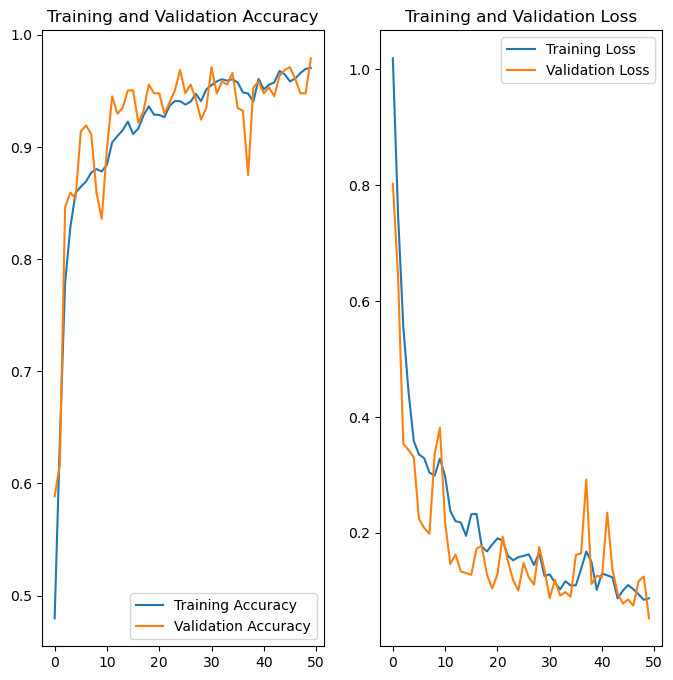

In [30]:
EPOCHS = 50

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

first image to predict
actual label: stripe_rust
1/1 [==============================] - 0s 243ms/step
predicted label: stripe_rust


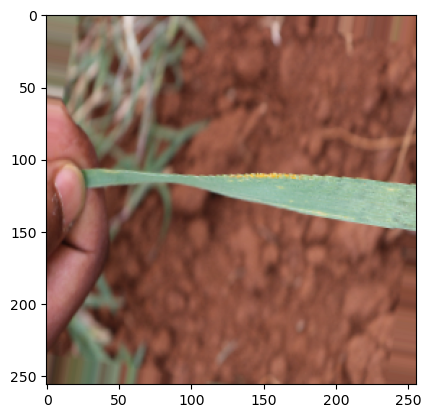

In [50]:
import numpy as np


for image_batch, label_batch in test_generator:
    first_image = image_batch[0]
    first_label = int(label_batch[0])
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    
    break

### Write a function for inference

In [31]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 [==============================] - 0s 32ms/step


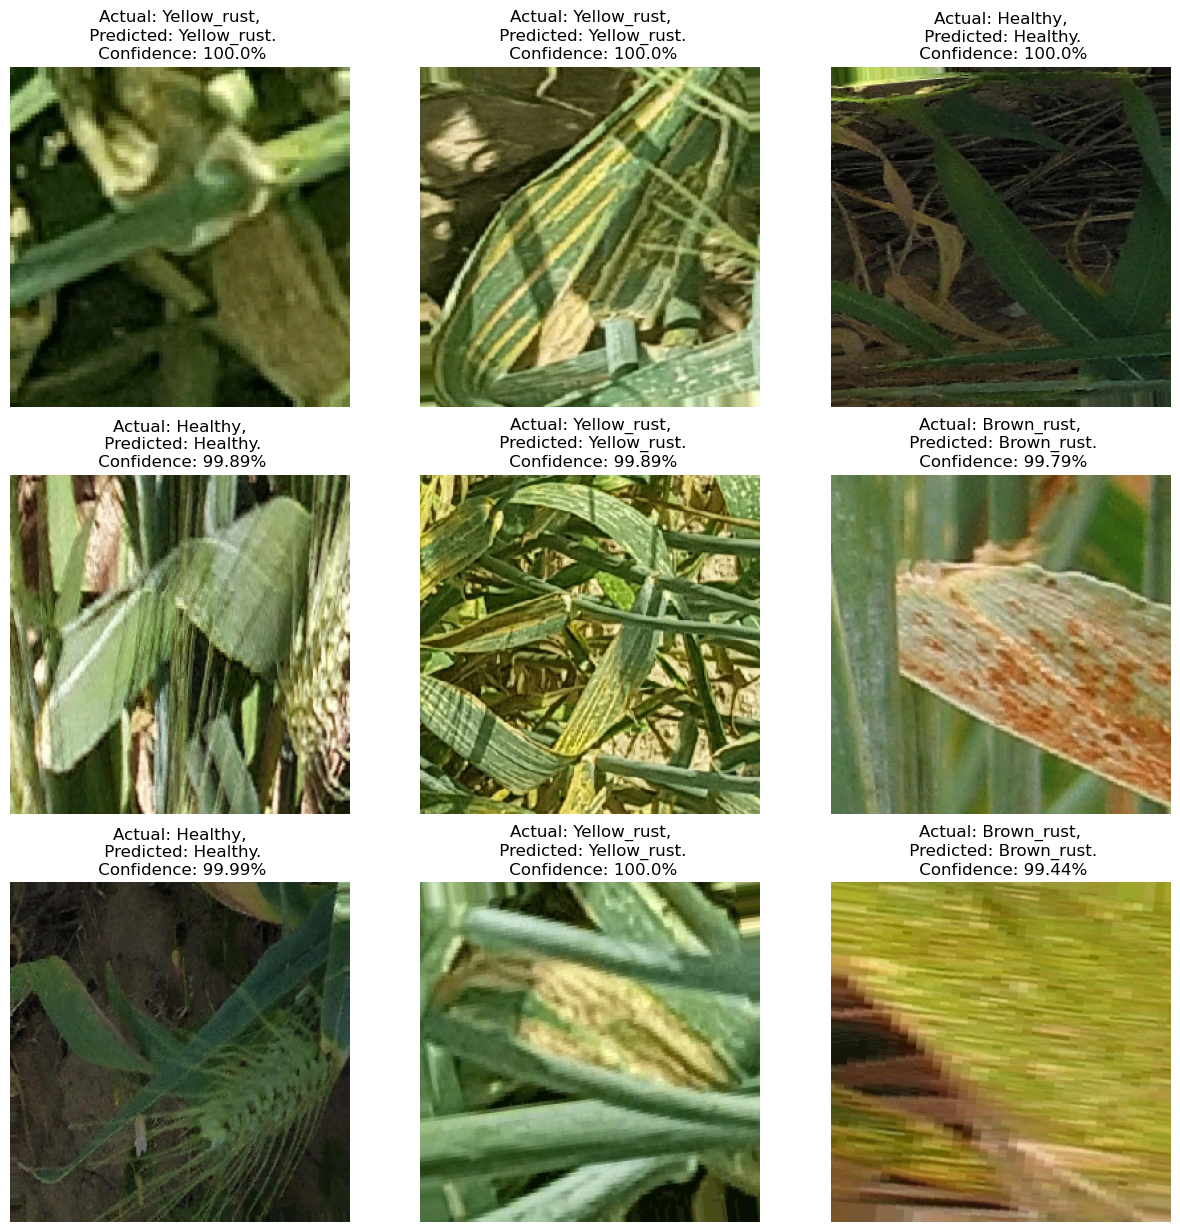

In [32]:
plt.figure(figsize=(15, 15))
for images, labels in test_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[int(labels[i])] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
    break

### Saving the Model

Save model in h5 format so that there is just one file and we can upload that to GCP conveniently

In [53]:
model.save("./model_v3.h5")

INFO:tensorflow:Assets written to: ./2\assets


INFO:tensorflow:Assets written to: ./2\assets
